# Makemore

Noted, Coded, and Created by Han Summer 2024. Part of The 20th Summer Project

------------
### Makemore

Making more things from the data given to the model.

Under the hood, **makemore is character level language model**, it means treating every single line example of data from the training set as a sequence of individual characters.

Character level language model, simpelnya cuman prediksi huruf yang selanjutnya berdasarkan sequence huruf yang udah ada (before it)

Bigram only takes 1 character as context to predict the next char. So the model didn't creating meaningful word, 

if we try to increase bigram approach to more character as context, the size of the context table would increase exponentialy

Table Size:
1 character -> 27 rows

2 character -> 27*27 = 729 rows

3 character -> 27*27*27

It too much, so we use try to use MLP approach

## MLP Makemore implementation

Paper source: [Bengio et al. 2003](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf), this paper doing word prediction. This implementation stick to character predicition.

Paper breakdown:
- This paper embbeds each word from vocabulary (17000 words) to 30, 60 or 100 dimensional feature vector
- Each 17000 words embedded randomly to 30 feature vectors, then the embedding would be tuned using backpropagation.
- Words that has similar meaning would ended up in similar position in the dimensional space
- Modeling approach -> Multi linear neural network to predict the next word given the previous ones
- Training -> maximize the log likelihood of the training data

**Structure of the model**

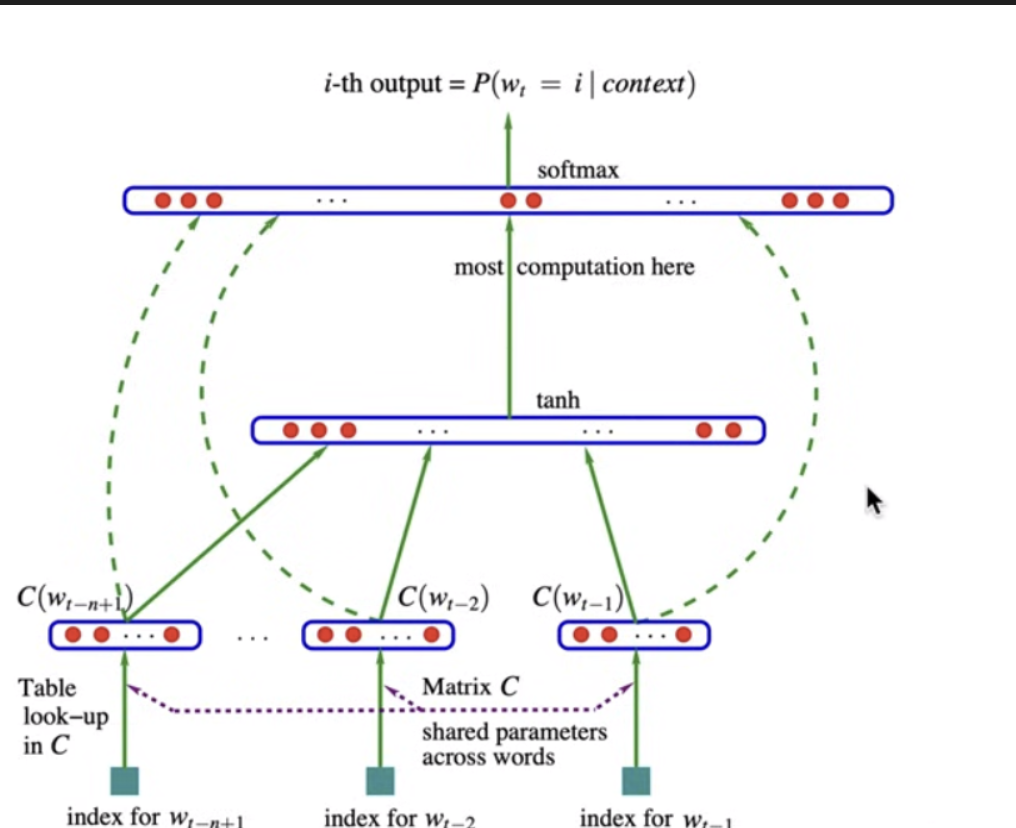

Figure explanation:

- Input part (3 words)
    - Taking 3 previous word and predict the fourth word
    - Each word -> 17000 possible word (vocabulary) and the index is int of 0-16999
    - There is a look-up table/embedding matrix C sized 17000 x 30 (17000 word and 30 dimension)
    - Setiap index word ngambil baris dari embedding matrix C. Each index converted to 30 dimension
    - Matrix C is shared across word, so there is 1 embedding matrix C and used to those 3 index
- Fully-connected hidden layer (tanh)
    - Size of the neural net is a hyperparameter, so we can choose the size by ourself
- Output layer (softmax)
    - There are 17000 words that could come next, so the number of the output layer is 17000 and all fully connected to hidden layer
    - The expensive layer

Parameters optimized using backpropagation:
- Weights and Biases on the layers
- Look up table

Parameters is optimized by trying to maximize the probability of the label word (the next word) with the respect of the NN parameters

## This part is my note on BNMLP implementation in pytorch style

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Dataset and Building vocabulary

The included `names.txt` dataset, as an example, has the most common 32K names takes from [ssa.gov](https://www.ssa.gov/oact/babynames/) for the year 2018.

In [14]:
# Open the dataset (List of names) as a python list of strings which is words in this case
word= open('names.txt', 'r').read().splitlines()

In [15]:
#First 10 word
word[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [16]:
len(word)

32033

In [17]:
#Building vocabulary
chars=sorted(list(set(''.join(word))))
stoi={c:i+1 for i,c in enumerate(chars)} #Mapping of character to index
stoi['.']=0 #Start/End token
itos={i:c for c,i in stoi.items()} #Mapping of index to character
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [18]:
vocab_size = len(itos)

### Building dataset + Split

In [19]:
#Breakdown of the dataset algorithm
block_size=3 #Context size: berapa karakter sebelum yang dipake buat predict selanjutnya
X, Y= [], []
for w in word: #First 5 words
    # print(w)
    context=[0]*block_size 
    for ch in w+'.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # print (''.join(itos[i] for i in context), '-->', itos[ix])
        context=context[1:]+[ix] #rolling window of the context, remove char in first idx and add new char in last idx

In [20]:
X = torch.tensor(X)
Y = torch.tensor(Y)

In [21]:
X,Y=X.to(device),Y.to(device)

In [22]:
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

X ->int64-> [228146, 3] -> 228146 examples (data) and each input to NN is 3 int

Y ->int64-> [228146] -> int label

3 char --> label char

context --> label

In [23]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(word)
n1 = int(0.8*len(word))
n2 = int(0.9*len(word))

Xtr,  Ytr  = build_dataset(word[:n1])     # 80%
Xdev, Ydev = build_dataset(word[n1:n2])   # 10%
Xte,  Yte  = build_dataset(word[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [24]:
Xtr,Ytr,Xdev,Ydev,Xte,Yte=Xtr.to(device),Ytr.to(device),Xdev.to(device),Ydev.to(device),Xte.to(device),Yte.to(device)

### Building Torch Style MLP (Modularized)

In [ ]:
#The linear layer, torch.nn.Linear, applies a linear transformation to the incoming data: y = xA^T + b
class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5 # xavier initialization in linear layer
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

#Batch Normalization layer
class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training: #When training
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else: #When testing
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad(): # update running mean and variance using a exponential moving average seperately to training process
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean #mini-batch mean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar #mini-batch variance
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd), generator=g)
#Layers with batch norm, and bias is removed
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]
# layers = [
#   Linear(n_embd * block_size, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, vocab_size),
# ]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1
  #layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 1.0 #5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

In [ ]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph, this is for mempertahankan gradient
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if i >= 1000:
    break # AFTER_DEBUG: would take out obviously to run full optimization